<a href="https://colab.research.google.com/github/rohandatta/Face_Recognition_Drowsiness_Detection/blob/main/Capstone_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Introduction

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to
the advancement of web-based learning services, specifically, eLearning platforms.
Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India
is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market
is growing on a rapid scale, there are major challenges associated with digital learning when
compared with brick and mortar classrooms. One of many challenges is how to ensure quality
learning for students. Digital platforms might overpower physical classrooms in terms of content
quality but when it comes to understanding whether students are able to grasp the content in a live
class scenario is yet an open-end challenge.
In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the
class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who
need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the
mood. Because of this drawback, students are not focusing on content due to lack of surveillance.
While digital platforms have limitations in terms of physical surveillance but it comes with the power of
data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves
the surveillance issue, but it also removes the human bias from the system, and all information is no
longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.


# Let's begin

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


{'haarcascade_frontalface_default.xml': b'<?xml version="1.0"?>\r\n<!--\r\n    Stump-based 24x24 discrete(?) adaboost frontal face detector.\r\n    Created by Rainer Lienhart.\r\n\r\n////////////////////////////////////////////////////////////////////////////////////////\r\n\r\n  IMPORTANT: READ BEFORE DOWNLOADING, COPYING, INSTALLING OR USING.\r\n\r\n  By downloading, copying, installing or using the software you agree to this license.\r\n  If you do not agree to this license, do not download, install,\r\n  copy or use the software.\r\n\r\n\r\n                        Intel License Agreement\r\n                For Open Source Computer Vision Library\r\n\r\n Copyright (C) 2000, Intel Corporation, all rights reserved.\r\n Third party copyrights are property of their respective owners.\r\n\r\n Redistribution and use in source and binary forms, with or without modification,\r\n are permitted provided that the following conditions are met:\r\n\r\n   * Redistribution\'s of source code must r

In [4]:
from google.colab import files
files.upload()

Saving Sachin_test.jpg to Sachin_test.jpg


{'Sachin_test.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\n\x07\x08\x12\x0f\r\n\x12\x10\x11\x08\n\n\x0c\x08\x0c\x08\x08\x08\x08\x08\x11\t\n\t\x0c\x18\x14\x19\x19\x18\x14\x16\x16\x1c!.%\x1c\x1e+\x1f\x16\x16&F&+/155C\x1a$;@;@[.451\x01\x0c\x0c\x0c\x10\x0f\x10\x1a\x12\x12\x1e4!\x18!4444144444144444414144411411144444414444411?414441\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x01\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x05\x06\x01\x07\xff\xc4\x00=\x10\x00\x01\x03\x02\x04\x03\x05\x06\x03\x07\x03\x05\x00\x00\x00\x00\x02\x00\x01\x03\x04\x12\x05\x11"2\x13!R\x06#3Bb1CSr\x82\x92\x14A\xd2\x15cs\xa2\xb2\xc2\xe2$\xb3\xf0DQaq\x93\xff\xc4\x00\x19\x01\x01\x00\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x03\x04\x01\x05\xff\xc4\x00(\x11\x00\x02\x01\x04\x01\x03\x03\x05\x01\x01\x00\x00\x00\x00\x00\x00\x00\x02\x01\x03\x04\x11\x12!"12\x13AB\x143R\x82\xf

In [13]:
def detect_face(image_path):
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    roigray = gray[y:y+h, x:x+w]
    roicolor = img[y:y+h, x:x+w]

  plt.grid(None)   
  plt.xticks([])
  plt.yticks([])
  imgplot = plt.imshow(img)

  return roicolor







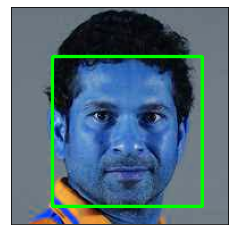

In [20]:
face = detect_face('Sachin_test.jpg')

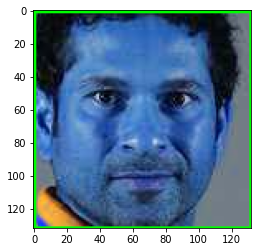

In [21]:
plt.imshow(face)

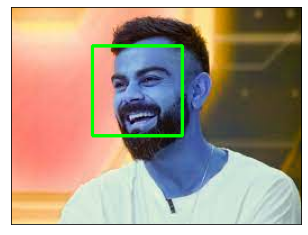

In [22]:
face = detect_face('Virat_test.jpg')

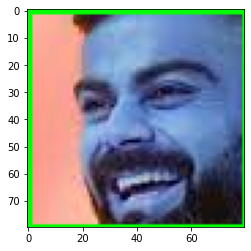

In [23]:
plt.imshow(face)